# **Imports 📢**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import R2Score
from tqdm import tqdm

from sklearn.metrics import r2_score

# **Dataset 🗂️**

## Read Dataset

In [3]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.drop('ocean_proximity' , axis=1 , inplace=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


## Split

In [5]:
train_set , test_set = train_test_split(df ,test_size=0.1 , random_state=0)
print(train_set.shape)
print(test_set.shape)

(18576, 9)
(2064, 9)


In [6]:
train_set , valid_set = train_test_split(train_set ,test_size=0.2 , random_state=0)
print(train_set.shape)
print(valid_set.shape)

(14860, 9)
(3716, 9)


## Preprocess

In [7]:
train_set.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        161
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [8]:
mean_feature = round(train_set['total_bedrooms'].mean())
mean_feature

539

In [9]:
train_set.fillna(mean_feature , inplace=True)
train_set.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [10]:
valid_set.fillna(mean_feature , inplace=True)
valid_set.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [11]:
test_set.fillna(mean_feature , inplace=True)
test_set.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [12]:
X_train = train_set.drop('median_house_value' , axis=1).values
y_train = train_set['median_house_value'].values
y_train = y_train[: , None]

X_valid = valid_set.drop('median_house_value' , axis=1).values
y_valid = valid_set['median_house_value'].values
y_valid = y_valid[: , None]

X_test = test_set.drop('median_house_value' , axis=1).values
y_test = test_set['median_house_value'].values
y_test = y_test[: , None]

In [13]:
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)
X_test = torch.FloatTensor(X_test)

y_train = torch.FloatTensor(y_train)
y_valid = torch.FloatTensor(y_valid)
y_test = torch.FloatTensor(y_test)

In [14]:
mu = torch.mean(X_train , dim=0)
std = torch.std(X_train , dim=0)

X_train = (X_train - mu) / std
X_valid = (X_valid - mu) / std
X_test = (X_test - mu) / std

In [15]:
mu_y = torch.mean(y_train)
std_y = torch.std(y_train)

y_train = (y_train - mu_y) / std_y
y_valid = (y_valid - mu_y) / std_y
y_test = (y_test - mu_y) / std_y

## Dataloader

In [16]:
train_dataset = TensorDataset(X_train , y_train)
valid_dataset = TensorDataset(X_valid , y_valid)
test_dataset = TensorDataset(X_test , y_test)

train_loader = DataLoader(train_dataset , 200 , True)
valid_loader = DataLoader(valid_dataset , 400)
test_loader = DataLoader(test_dataset , 400)

# **Model 🧠**

In [86]:
in_features = 8
h1 = 12
h2 = 4
out_features = 1

model = nn.Sequential(nn.Linear(in_features , h1),
                      nn.ReLU(),
                      
                      nn.Linear(h1 , h2),
                      nn.ReLU(),
                      
                      nn.Linear(h2 , out_features),
                     )

model

Sequential(
  (0): Linear(in_features=8, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

# **Device ⚙️**

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# **Loss ⚖️**

## MSELoss

In [32]:
mse_loss = nn.MSELoss()

## N1Loss

In [39]:
mae_loss = nn.L1Loss()

## HuberLoss

In [21]:
huber_loss = nn.HuberLoss()

## AdaptiveLoss

In [22]:
def adaptive_loss(y_hat , y , c , alpha):

    if alpha == 2:
        return torch.mean(0.5*((y-y_hat) / c)**2)

    elif alpha == 0:
        return torch.mean(torch.log(0.5*((y-y_hat) / c)**2 + 1))

    elif alpha <= -1e4:
        return torch.mean(1 - torch.exp(-0.5*((y-y_hat) / c)**2))

# **Optimizer📻**

## Adam

In [88]:
optimizer_adam = torch.optim.Adam(model.parameters() , lr=0.01)

## SGD

In [66]:
optimizer_sgd = torch.optim.SGD(model.parameters() , lr=0.01)

## SGD_M

In [73]:
optimizer_sgd_momentum = torch.optim.SGD(model.parameters() , lr=0.01 , momentum=0.9)

## SGD_Nest

In [78]:
optimizer_sgd_momentum_nestrov = torch.optim.SGD(model.parameters() , lr=0.01 , momentum=0.9 , nesterov=True)

## rmsprop

In [83]:
optimizer_rmsprop = torch.optim.RMSprop(model.parameters() , lr=0.01)

# **Utils 🧰**

In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Train Loop👨🏼‍🏫**

In [89]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

num_epochs = 300

for epoch in range(num_epochs):
    # Train
    model.train()
    loss_train = AverageMeter()
    acc_train = R2Score()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = adaptive_loss(outputs, targets , c=2 , alpha=0)

        loss.backward()
        optimizer_adam.step()
        optimizer_adam.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets)

    loss_train_hist.append(loss_train.avg)
    acc_train_hist.append(acc_train.compute())

    # Validation
    model.eval()
    loss_valid = AverageMeter()
    acc_valid = R2Score()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = adaptive_loss(outputs, targets , c=2 , alpha=0)

            loss_valid.update(loss.item())
            acc_valid(outputs, targets)

        loss_valid_hist.append(loss_valid.avg)
        acc_valid_hist.append(acc_valid.compute())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}')
        print(f'Train: Loss = {loss_train.avg:.4}, R2Score = {acc_train.compute():.4}')
        print(f'Valid: Loss = {loss_valid.avg:.4}, R2Score = {acc_valid.compute():.4}')
        print()

Epoch 0
Train: Loss = 0.08131, R2Score = 0.208
Valid: Loss = 0.06315, R2Score = 0.4303

Epoch 10
Train: Loss = 0.03147, R2Score = 0.7226
Valid: Loss = 0.03261, R2Score = 0.7212

Epoch 20
Train: Loss = 0.03073, R2Score = 0.7288
Valid: Loss = 0.03157, R2Score = 0.7312

Epoch 30
Train: Loss = 0.03058, R2Score = 0.7309
Valid: Loss = 0.03238, R2Score = 0.7257

Epoch 40
Train: Loss = 0.03013, R2Score = 0.7338
Valid: Loss = 0.03195, R2Score = 0.7263

Epoch 50
Train: Loss = 0.03017, R2Score = 0.7343
Valid: Loss = 0.03213, R2Score = 0.7297

Epoch 60
Train: Loss = 0.02825, R2Score = 0.7505
Valid: Loss = 0.02985, R2Score = 0.7448

Epoch 70
Train: Loss = 0.02782, R2Score = 0.7551
Valid: Loss = 0.02912, R2Score = 0.7501

Epoch 80
Train: Loss = 0.02791, R2Score = 0.754
Valid: Loss = 0.02908, R2Score = 0.7543

Epoch 90
Train: Loss = 0.02737, R2Score = 0.7581
Valid: Loss = 0.02889, R2Score = 0.7533

Epoch 100
Train: Loss = 0.02737, R2Score = 0.7582
Valid: Loss = 0.02869, R2Score = 0.7571

Epoch 110
Tr

In [90]:
optim = 'adam'

torch.save(torch.tensor(acc_train_hist), f'save/{optim}-acc-train.pt')
torch.save(torch.tensor(acc_valid_hist), f'save/{optim}-acc-valid.pt')

torch.save(torch.tensor(loss_train_hist), f'save/{optim}-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'save/{optim}-loss-valid.pt')

# **Comparison🔎**

## Plot

In [91]:
def plot_lcs(x:str, y:str):
    plt.figure(figsize=(8, 6))

    for optim in ['sgd', 'sgd-m', 'sgd-nest', 'rms', 'adam']:
        
        z = torch.load(f'save/{optim}-{x}-{y}.pt')

        plt.plot(range(num_epochs), z, label=optim)
        plt.xlabel('epoch')
        plt.ylabel(f'{x} {y}')
        plt.grid(True)
        plt.legend()

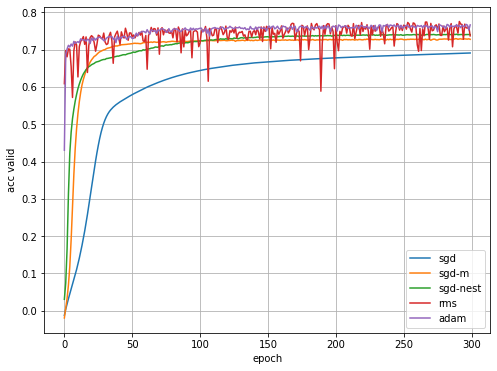

In [94]:
plot_lcs('acc', 'valid')

## R2 score

Loss     | MSELoss  | N1Loss  | HuberLoss | AdaptiveLoss
---------|----------|---------|-----------|------------------
R2 score |    0.7769      | 0.7778        |0.7644           |0.78